由于ImageNet数据集太大，所以这里不复现论文中攻击inception resnet v2，而是使用CIFAR-10数据集。攻击的模型是[resnet20预先训练好的模型](https://github.com/akamaster/pytorch_resnet_cifar10)。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from resnet import resnet20
from util import l, r

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
model_path = './model/resnet20-12fca82f.th'
target_model = torch.nn.DataParallel(resnet20())
target_model.load_state_dict(torch.load(model_path)['state_dict'], strict=True)

<All keys matched successfully>

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data/', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

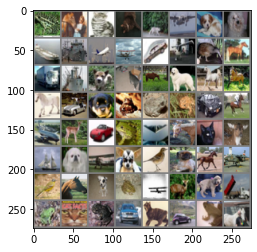

 frog horse   cat   cat   cat plane   dog   dog  ship  ship plane plane   car plane  bird horse truck  ship   dog   cat horse   dog horse horse horse   car   dog  frog  frog  frog   car horse plane  deer   car  frog plane horse   cat  deer  ship   dog plane   dog  bird   dog horse plane  bird horse   dog  frog plane  deer   dog truck  frog   cat  frog   car   cat   car  frog horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
def test_resnet(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%")

test_resnet(testloader, target_model)

Accuracy: 83.9%


In [7]:
class AAE_ATN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 512, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),
            nn.Tanh(),
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        out = out.view(out.size()[0], 3, 32, 32)
        return out
        
        
model_AAE = AAE_ATN().to(device)

In [8]:
class P_ATN(nn.Module):
    def __init__(self, epsilon = 0.1):
        super().__init__()
        self.epsilon = epsilon
        self.conv = nn.Sequential(
            nn.Conv2d(3, 512, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        out = out.view(out.size()[0], 3, 32, 32)
        out = out * self.epsilon
        out = x + out
        out = torch.clamp(out, -1, 1)
        return out
        
model_P = P_ATN().to(device)

In [9]:
learning_rate = 1e-3
loss_fn = l
target = 1
b = 10000

In [10]:
def train(dataloader, model, target_model, loss_fn, optimizer):
    model.train()
    for param in target_model.parameters():
        param.requires_grad = False
    size = len(dataloader.dataset)
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        optimizer.zero_grad()
        target_model.zero_grad()
        generate = model(X)
        pred_raw = target_model(X)
        pred_generate = target_model(generate)
        loss = 0
        if isinstance(model, AAE_ATN):
            loss = loss_fn(X, generate, pred_raw, pred_generate, b, target, r)
        elif isinstance(model, P_ATN):
            loss = loss_fn(X, generate, pred_raw, pred_generate, 1e-9, target, r)

        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item() / len(X), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
# train AAE-ATN
epochs = 10
optimizer_AAE = torch.optim.Adam(model_AAE.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model_AAE, target_model, loss_fn, optimizer_AAE)

print("Done!")

Epoch 1
-------------------------------
loss: 43.576939  [    0/50000]
loss: 15.237350  [ 6400/50000]
loss: 10.278374  [12800/50000]
loss: 9.445934  [19200/50000]
loss: 8.553423  [25600/50000]
loss: 8.056252  [32000/50000]
loss: 8.103863  [38400/50000]
loss: 6.650546  [44800/50000]
Epoch 2
-------------------------------
loss: 7.210698  [    0/50000]
loss: 6.506872  [ 6400/50000]
loss: 6.508080  [12800/50000]
loss: 6.225746  [19200/50000]
loss: 6.211658  [25600/50000]
loss: 5.894037  [32000/50000]
loss: 6.050138  [38400/50000]
loss: 5.994193  [44800/50000]
Epoch 3
-------------------------------
loss: 6.102516  [    0/50000]
loss: 5.948359  [ 6400/50000]
loss: 4.994150  [12800/50000]
loss: 5.474285  [19200/50000]
loss: 5.236221  [25600/50000]
loss: 5.605496  [32000/50000]
loss: 4.561605  [38400/50000]
loss: 5.262709  [44800/50000]
Epoch 4
-------------------------------
loss: 4.591551  [    0/50000]
loss: 4.789246  [ 6400/50000]
loss: 4.603568  [12800/50000]
loss: 5.275171  [19200/5000

In [12]:
# train P-ATN
epochs = 10
optimizer_P = torch.optim.Adam(model_P.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model_P, target_model, loss_fn, optimizer_P)

print("Done!")

Epoch 1
-------------------------------
loss: 2.220717  [    0/50000]
loss: 1.305940  [ 6400/50000]
loss: 1.062846  [12800/50000]
loss: 1.013170  [19200/50000]
loss: 0.839405  [25600/50000]
loss: 1.008726  [32000/50000]
loss: 1.094709  [38400/50000]
loss: 0.973136  [44800/50000]
Epoch 2
-------------------------------
loss: 0.918950  [    0/50000]
loss: 0.856633  [ 6400/50000]
loss: 1.098557  [12800/50000]
loss: 0.809781  [19200/50000]
loss: 0.944309  [25600/50000]
loss: 1.133307  [32000/50000]
loss: 0.870109  [38400/50000]
loss: 0.798281  [44800/50000]
Epoch 3
-------------------------------
loss: 0.830952  [    0/50000]
loss: 0.769873  [ 6400/50000]
loss: 0.710844  [12800/50000]
loss: 0.985858  [19200/50000]
loss: 0.860219  [25600/50000]
loss: 1.019172  [32000/50000]
loss: 0.842760  [38400/50000]
loss: 0.860678  [44800/50000]
Epoch 4
-------------------------------
loss: 0.896578  [    0/50000]
loss: 0.768371  [ 6400/50000]
loss: 0.894656  [12800/50000]
loss: 0.926996  [19200/50000]


target class: car


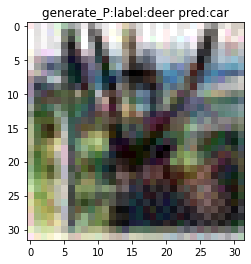

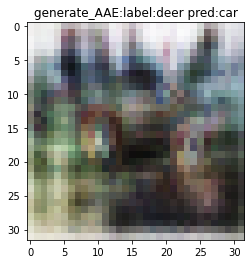

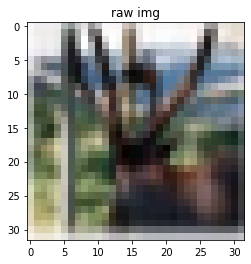

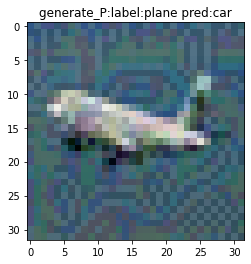

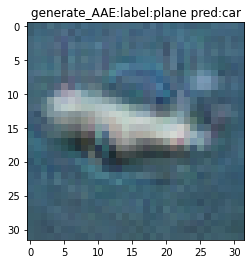

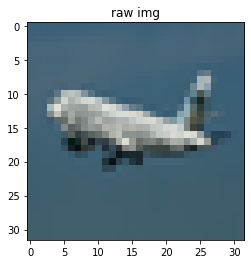

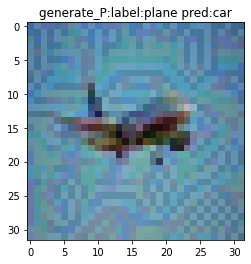

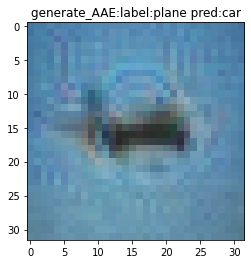

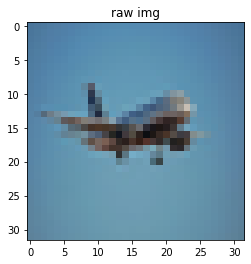

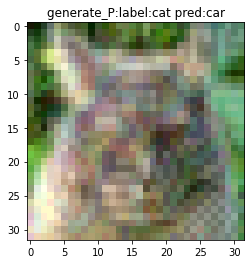

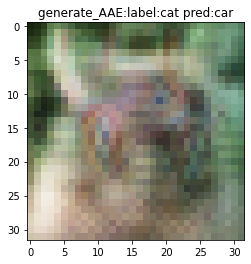

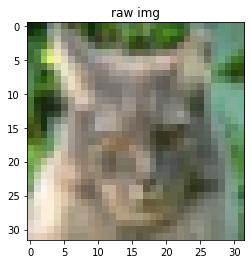

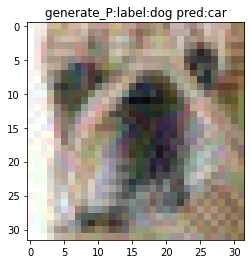

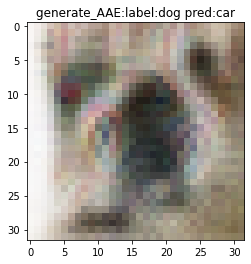

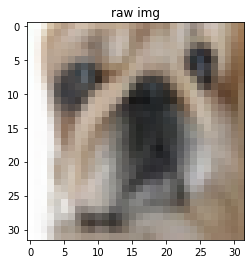

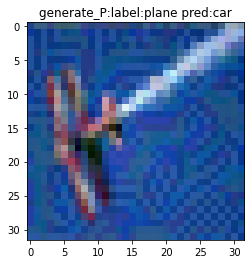

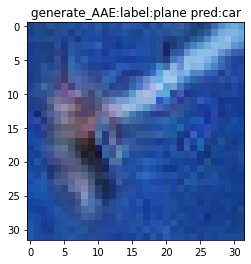

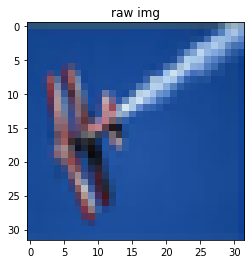

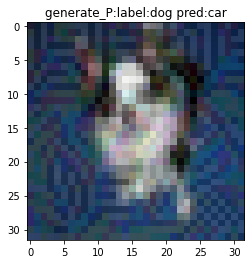

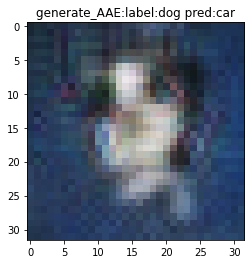

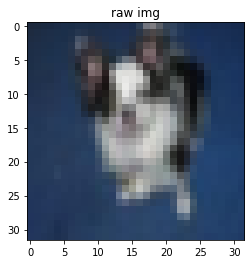

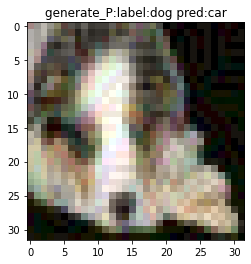

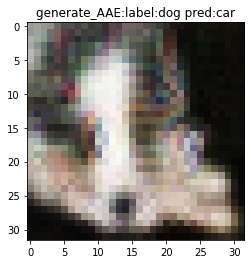

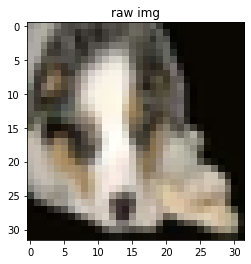

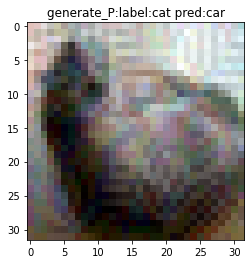

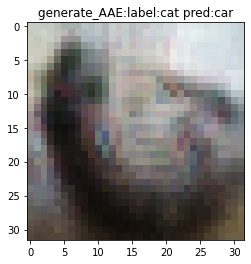

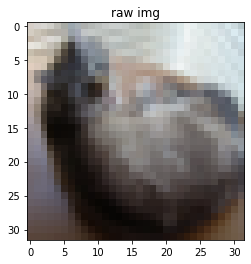

In [14]:
print('target class:', classes[target])

for i in range(1, 10):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    
    generate_P = model_P(img.unsqueeze(0).to(device))
    generate_AAE = model_AAE(img.unsqueeze(0).to(device))

    pred_raw =  target_model(img.unsqueeze(0).to(device))
    pred_generate_P = target_model(generate_P)
    pred_generate_AAE = target_model(generate_AAE)

    _, idx_raw = pred_raw.sort(dim=1, descending=True)
    _, idx_generate_P = pred_generate_P.sort(dim=1, descending=True)
    _, idx_generate_AAE = pred_generate_AAE.sort(dim=1, descending=True)

    plt.title('generate_P:' + 'label:' + classes[label] + ' ' + 'pred:' + classes[idx_generate_P[0][0].item()])
    generate_P = generate_P.squeeze().cpu()
    generate_p = torchvision.utils.make_grid(generate_P)
    imshow(generate_p)

    plt.title('generate_AAE:' + 'label:' + classes[label] + ' ' + 'pred:' + classes[idx_generate_AAE[0][0].item()])
    generate_AAE = generate_AAE.squeeze().cpu()
    generate_AAE = torchvision.utils.make_grid(generate_AAE)
    imshow(generate_AAE)

    plt.title('raw img')
    imshow(torchvision.utils.make_grid(img))
plt.show()